In [25]:
# Jupyter will automaticaly reload libraries if they have been modified
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [ ]:
The data used to train the classifier comes from the [INRIA person dataset](http://pascal.inrialpes.fr/data/human/)

In [26]:
from tool_library import datasets

/home/selimsepthuit/anaconda3/envs/test-ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
data = datasets.InriaPersonDataset("INRIAPerson")

100%|██████████| 545/545 [00:05<00:00, 98.13it/s] 


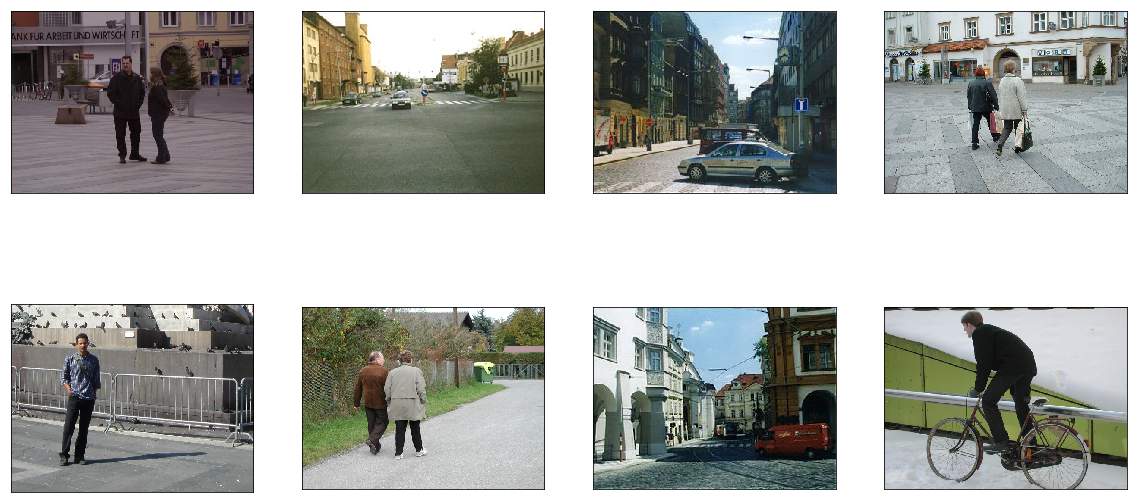

In [28]:
data.examples(sample="Test", number=8)

In [29]:
data.statistics()

neg  pos Total
Classes                 
Train     860  423  1283
Valid     356  189   545
Test      453  288   741
         1669  900  2569

In [53]:
from tool_library.gapModels import MobileNetGAP

# model = MobileNetGAP(nb_classes=2)
model = MobileNetGAP(path='saved_model/mobilenet.h5')

In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 16)      64        
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 16)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 16)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 16)      144       
__________

In [64]:
from tool_library.classifier import Classifier
clf = Classifier(model, name='mobilenet')
clf.fit(data, epochs=2, batch_size=32, augmentation=False, verbose=2)

Train on 1283 samples, validate on 545 samples
Epoch 1/2
 - 11s - loss: 0.0633 - acc: 0.9945 - val_loss: 0.0805 - val_acc: 0.9853
Epoch 2/2
 - 11s - loss: 0.0758 - acc: 0.9891 - val_loss: 0.1647 - val_acc: 0.9358


In [57]:
import cv2
img_path = 'INRIAPerson/Test/pos/person_064.png'
img = cv2.imread(img_path)

In [58]:
clf.predict(img, decision=False)

[0.00857914, 0.99142087]

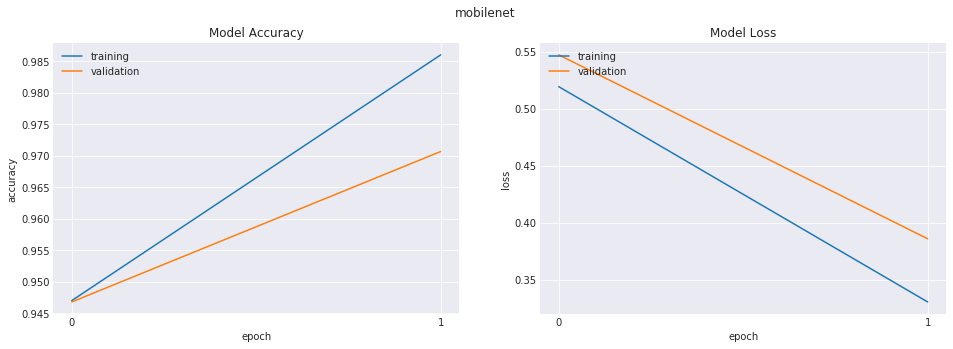

In [40]:
clf.learning_curves()

To view the Tensorboard logs:
```
tensorboard --logdir=./tensorboard_logs
```
The Tensorboard page can then be found on port `6006`  

In [59]:
print(model.dense_layer_name)

dense_layer


In [60]:
img, prediction = clf.cam(img, class_number=1)

dense_layer
conv_pw_13_relu


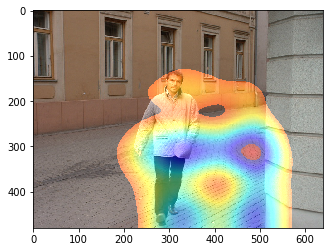

In [61]:
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.imshow(img)

# Table of Contents
- [Data](#Data)
    - Loading the dataset
    - Pre-processing the data
    - Visualizing the First 21 Training Images
    
    
- [Implementation](#Implementation)
    - Without transfer learning
    - With transfert learning

In [74]:
import tensorflow, keras, cv2
from keras import backend as K

def check():
    """
    Check dependencies and wether a GPU is being used
    """
    try:
        version = float(tensorflow.__version__[:3])
        assert(version>=1.7)
        
    except AssertionError: 
        print("Tensorflow version = {} < 1.7".fromat(version))
        
    try:
        version = float(keras.__version__[:3])
        assert(version>=2)
    except AssertionError: 
        print("Keras version = {} < 2".fromat(version))
    
    try:
        version = float(cv2.__version__[:3])
        assert(version>=3)
        print("Keras version = {} < 3".fromat(version))
    except AssertionError: 
        
    print("Resolving Unsatisfied Dependencies: \n\n\tconda install defaults::keras conda-forge::tensorflow \n\tconda install opencv ")
        
    print('{} GPU detected.'.format(len(K.tensorflow_backend._get_available_gpus())))

In [75]:
check()

1 GPU detected.


In [69]:
K.tensorflow_backend._get_available_cpus()

AttributeError: module 'keras.backend.tensorflow_backend' has no attribute '_get_available_cpus'

# Data
---

## Loading the dataset

The data used to train the classifier comes from the [INRIA person dataset](http://pascal.inrialpes.fr/data/human/), or VOC2012

Direct link: [download](ftp://ftp.inrialpes.fr/pub/lear/douze/data/INRIAPerson.tar)  (970MBB tar file)

In [179]:
# Remove the files that won't be used in the project
rm_unused_folders('INRIAPerson/')

# Initialy the INRIA person dataset doesn't contain a Valid folder
create_validation_data_folder('INRIAPerson/', proportion=0.3)

In [180]:
# Load train and test datasets
train_files, train_targets, classes = load_dataset('INRIAPerson/Train/')
valid_files, valid_targets, classes = load_dataset('INRIAPerson/Valid/')
test_files , test_targets , classes = load_dataset('INRIAPerson/Test/')

In [181]:
# Statistics about the dataset
stats(classes, train_targets, valid_targets, test_targets)

Classes: ['neg', 'pos']
Total images 		:  1737
Training images 	:  868  	 =  423 pos + 445 neg
Validation images 	:  367  	 =  189 pos + 178 neg
Test images 		:  502  	 =  288 pos + 214 neg


## Visualising the data

In [21]:
show_examples(train_files, number=10)

NameError: name 'show_examples' is not defined

## Pre-processing the data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape:

$$
(\text{nb_samples}, \ \text{rows}, \ \text{columns}, \ \text{channels})
$$

- `nb_samples` = total number of images (or samples)
- `rows`, `columns`, `channels` = number of rows, columns, channels for each image, respectively 

In [183]:
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors  = paths_to_tensor(test_files)

100%|██████████| 502/502 [00:07<00:00, 68.19it/s]


# Implementation
---

## Without transfer learning

### Model

The architecture used here (recomanded by Keras for [classification with little data](https://blog.keras.io/index.html)) consists in a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. With the exception of ReLU, this is similar to the architectures that Yann LeCun advocated in the 1990s for image classification.

- We use `ReLU` activation functions to solve the vanishing gradient problem.
- We use `MaxPooling` to reduce the dimentionality after each convolution layer.
- We finish with two dense layers. The last layer has 133 nodes since there are 133 possible categories.
- Since we are constructing a multi-class classification we use `softmax` as the activation function of the last dense layer. 
- We use [L2 regularization](https://keras.io/regularizers/) and [Batch Normalization](https://keras.io/layers/normalization/) to tackle overfitting.

In [23]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def Time():
    """
    Measures and yields elapsed time
    """
    start = default_timer()
    elapsed = lambda: default_timer() - start
    yield lambda: elapsed()
    end = default_timer()
    elapsed = lambda: end-start

In [10]:
classes = ['neg', 'pos']

In [179]:
from models import mobilenet, vgg16, resnet50

In [180]:
model, name_of_final_conv_layer, name_of_dense_layer = mobilenet.get_model(nb_classes=len(classes), summary=False)

### Training

In [181]:
model_name = 'M1'

epochs = 15
batch_size = 64
data_augmentation = False

model_name += ' epochs='            + str(epochs) \
            + ' batch_size='        + str(batch_size) \
            + ' data_augmentation=' + str(data_augmentation)

In [182]:
if data_augmentation: 
    # With data augmentation 
    history = train_generator(model, 
                            model_name, 
                            data.X_train, 
                            data.y_train, 
                            data.X_valid, 
                            data.y_valid,
                            epochs       = epochs, 
                            batch_size   = batch_size, 
                            verbose=[1,0])
else:
    # Without data augmentation 
    history = train(model, 
                    model_name, 
                    data.X_train, 
                    data.y_train, 
                    data.X_valid, 
                    data.y_valid,
                    epochs     = epochs, 
                    batch_size = batch_size,  
                    verbose    = [1,0])


Epoch 00001: val_loss improved from inf to 0.62000, saving model to saved_model_weights/M1 epochs=15 batch_size=64 data_augmentation=False.hdf5

Epoch 00002: val_loss improved from 0.62000 to 0.41821, saving model to saved_model_weights/M1 epochs=15 batch_size=64 data_augmentation=False.hdf5

Epoch 00003: val_loss improved from 0.41821 to 0.34729, saving model to saved_model_weights/M1 epochs=15 batch_size=64 data_augmentation=False.hdf5

Epoch 00004: val_loss improved from 0.34729 to 0.28709, saving model to saved_model_weights/M1 epochs=15 batch_size=64 data_augmentation=False.hdf5

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss improved from 0.28709 to 0.21113, saving model to saved_model_weights/M1 epochs=15 batch_size=64 data_augmentation=False.hdf5

Epoch 00009: val_loss improved from 0.21113 to 0.14757, saving model to saved_model_weights/M1 epochs=15 batch_size=64 data_augmentation=Fals

### Evaluation

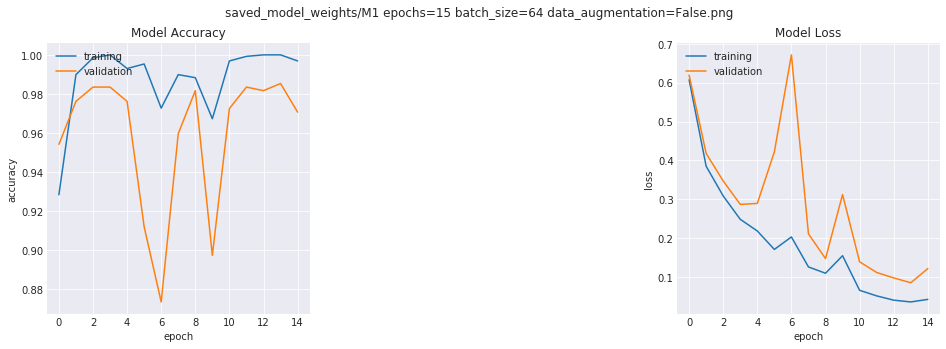

In [183]:
from IPython.display import Image
try:
    learning_curves(history, 'saved_model_weights/' + model_name + '.png')
except NameError:
    img = Image(filename='saved_model_weights/' + model_name + '.png') 
    display(img)

In [76]:
# Loading the model with the best validation loss
model.load_weights('saved_model_weights/' + model_name + '.h5')

In [81]:
# from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

In [79]:
mname = 'saved_model_weights/' + model_name + '.h5'

In [48]:
compute_accuracy(model, data.X_test, data.y_test)

Test accuracy: 97.3009%


In [83]:
model.evaluate(data.X_test, data.y_test)

741/741 [==============================] - 5s 7ms/step


[0.5107056049682833, 0.931174089149264]

In [84]:
from tools import *

In [140]:
# quick_test_no_show(model, data.X_test, data.y_test, 10)

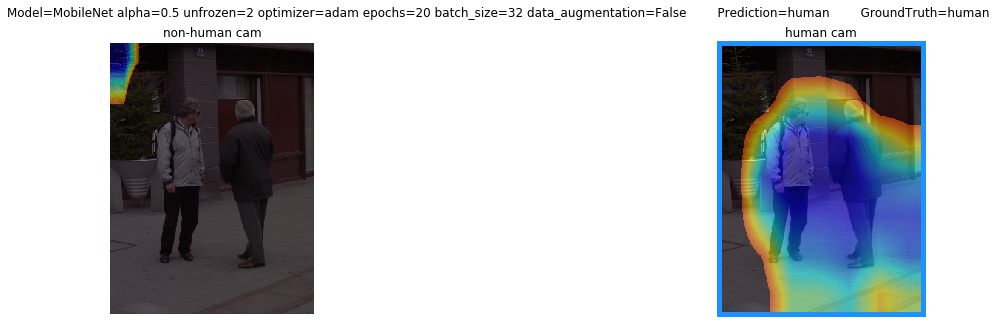

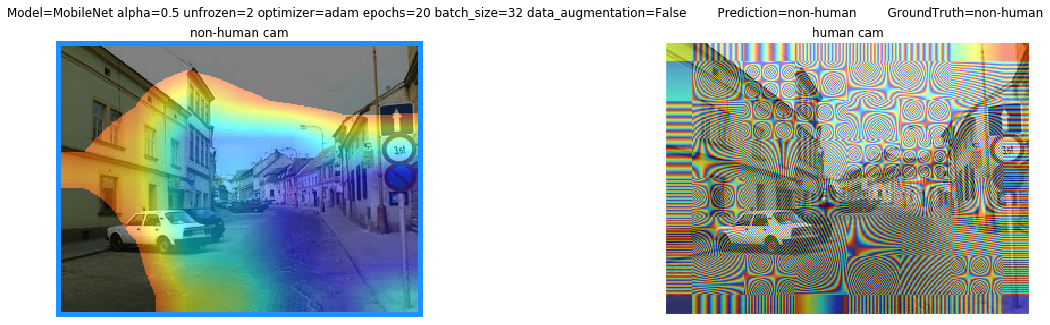

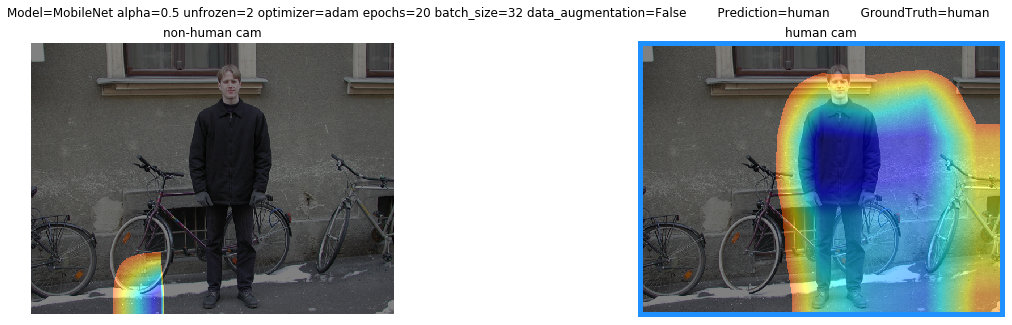

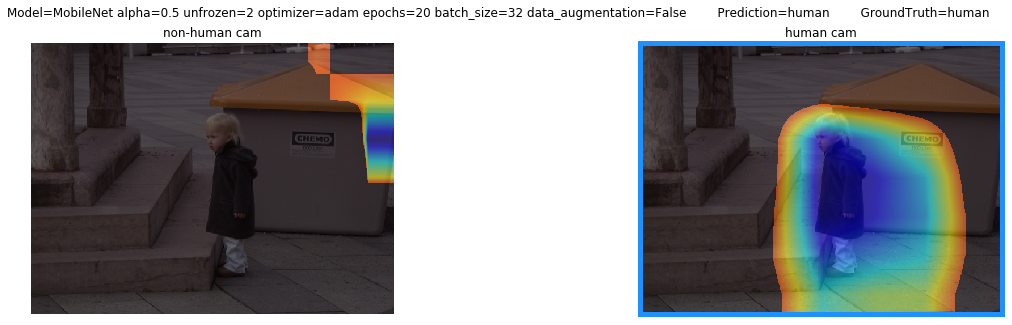

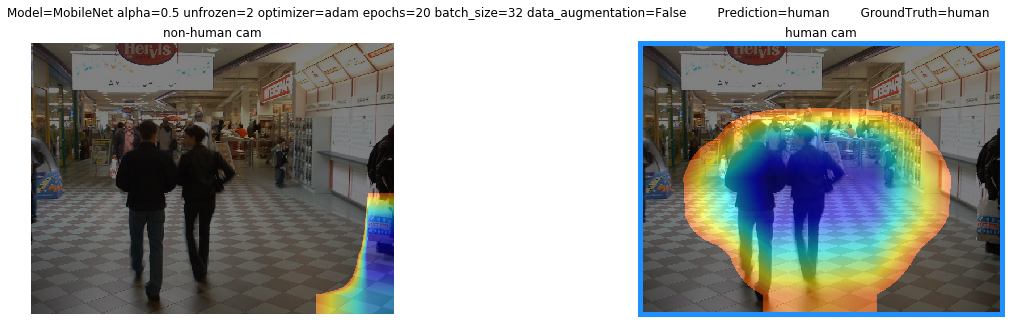

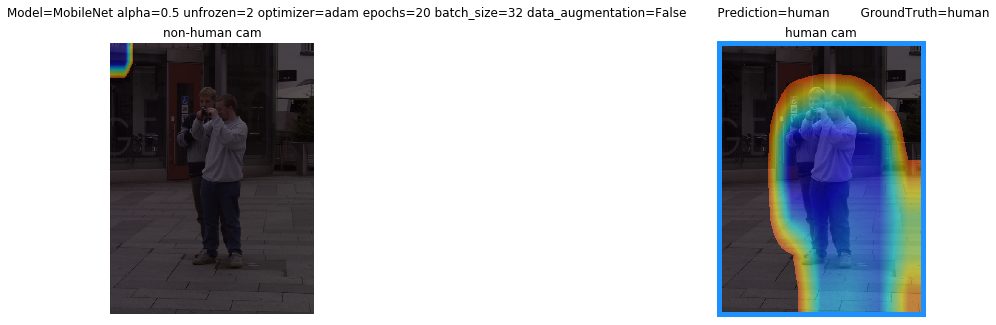

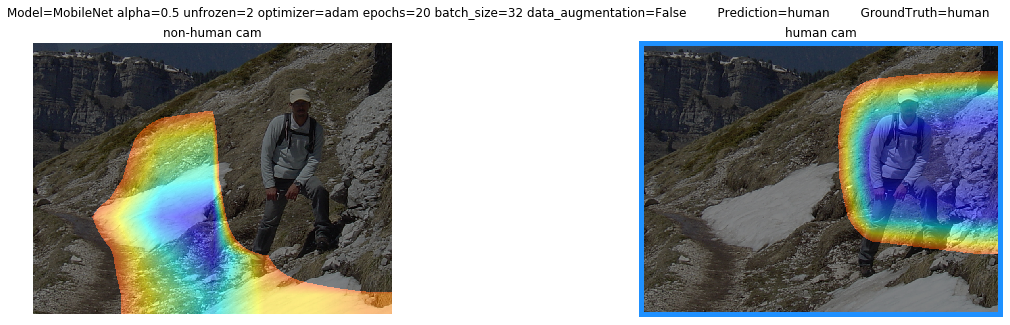

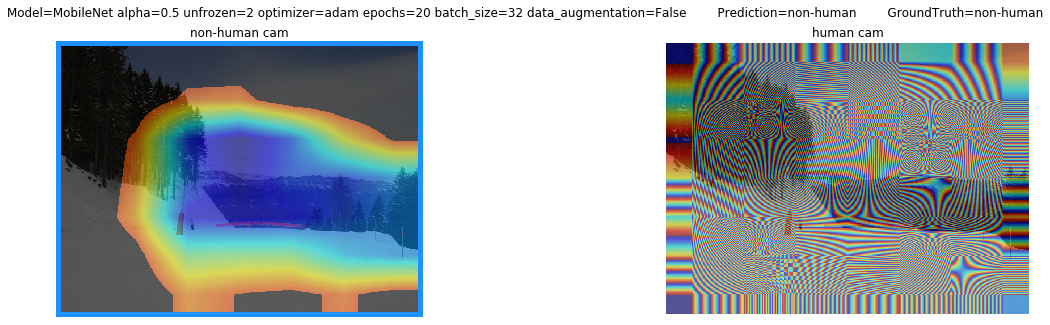

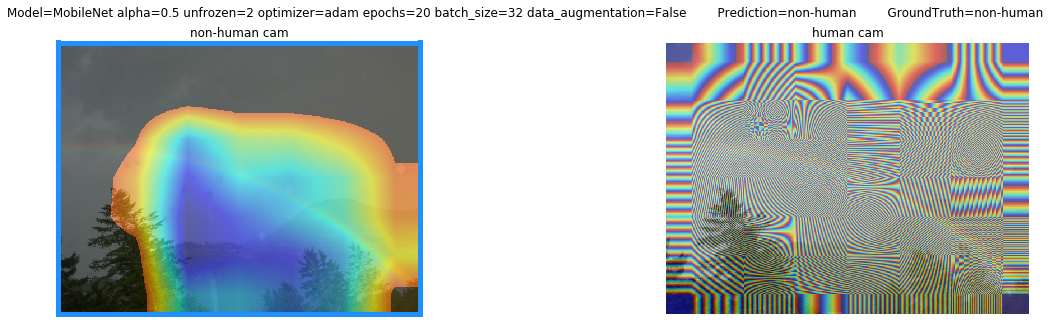

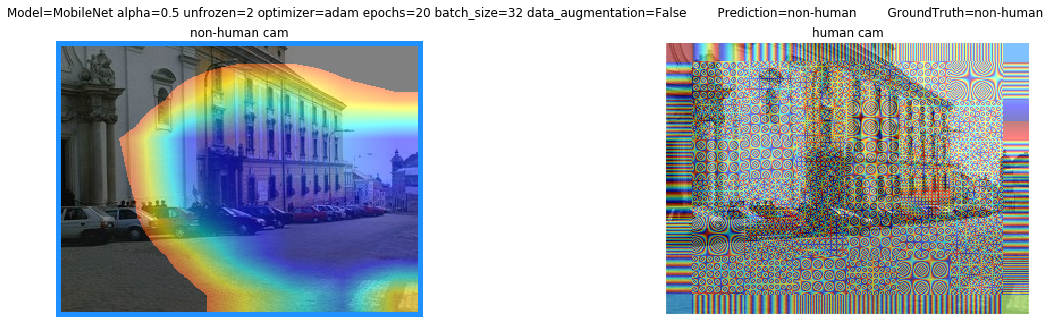

In [146]:
%matplotlib inline

name_of_final_conv_layer='conv_pw_13_relu'
name_of_dense_layer='dense_layer'
quick_test(model, model_name, test_files, test_targets, 10, name_of_final_conv_layer, name_of_dense_layer)

In [138]:
img_path = 'INRIAPerson/Test/pos/person_064.png'
img = cv2.imread(img_path)
img, prediction = cam(model, img, name_of_final_conv_layer, name_of_dense_layer, 1)
# img = class_activation_map(model, img_path, name_of_final_conv_layer, name_of_dense_layer, 1)

0.39437607


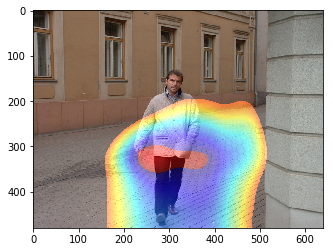

In [139]:
print(prediction)
plt.imshow(img)
plt.show()

0.5393178


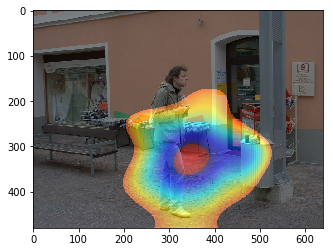

In [103]:
print(prediction)
plt.imshow(img)
plt.show()

In [167]:
filename='saved_model_weights/' + model_name + '.png'

In [168]:
filename

'saved_model_weights/MobileNet alpha=0.5 unfrozen=2 optimizer=adam epochs=20 batch_size=32 data_augmentation=False.png'

In [166]:
d = dict(p1=1, p2=2)
def f2(p1,p2):
    print(p1, p2)
f2(**d)

SyntaxError: invalid syntax (<ipython-input-166-fd2e11621541>, line 1)